In [1]:
image_paths = [
    '/export/space0/tanabe-h/data/animal/cat/458000.jpg',
    '/export/space0/tanabe-h/data/animal/dog/415000.jpg',
    '/export/space0/tanabe-h/data/animal/elephant/107000.jpg',
    '/export/space0/tanabe-h/data/animal/fish/209005.jpg',
    '/export/space0/tanabe-h/data/animal/penguin/541001.jpg',
]
true_labels = [281, 194, 386, 395, 145]

In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

# ResNet18モデルの読み込み
model = models.resnet18(pretrained=True, num_classes=1000)

# 画像の前処理の定義
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 分類する画像の読み込み
img_path = image_paths[2]
img = Image.open(img_path)

# 画像の前処理
img_t = transform(img)
batch_t = torch.unsqueeze(img_t, 0)

# 推論の実行
model.eval()
out = model(batch_t)

# 分類ラベルの読み込み
with open('imagenet_classes.txt') as f:
    classes = [line.strip() for line in f.readlines()]

# 上位5つの分類結果を表示
_, indices = torch.sort(out, descending=True)
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
for i in range(5):
    print("{}. {} ({:.2f}%) {}".format(i+1, classes[indices[0][i]], percentage[indices[0][i]].item(),indices[0][i]))


/home/yanai-lab/tanabe-h/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yanai-lab/tanabe-h/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


1. African elephant (78.02%) 386
2. tusker (19.26%) 101
3. Indian elephant (2.72%) 385
4. triceratops (0.00%) 51
5. Arabian camel (0.00%) 354


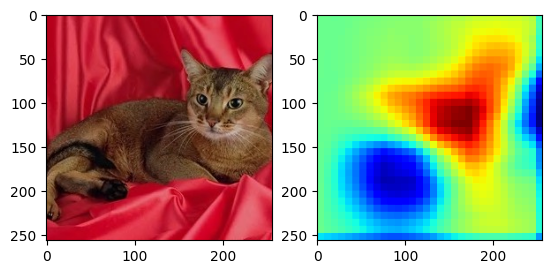

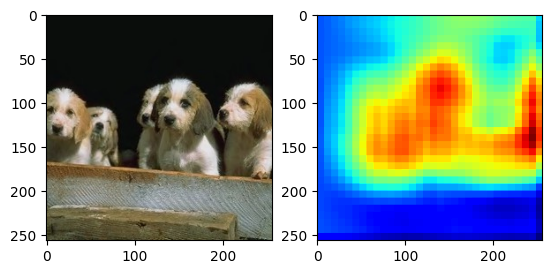

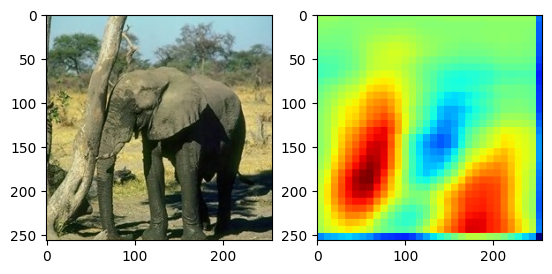

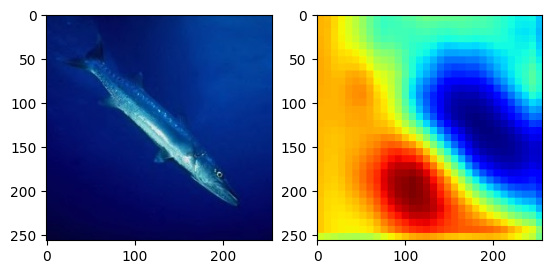

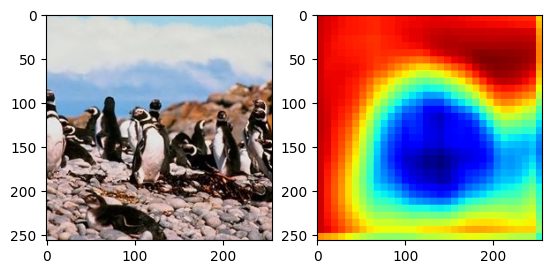

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# Load pre-trained MobileNetV2 model
model = torchvision.models.mobilenet_v2(pretrained=True)
model.eval()

# Data transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def predict(img_tensor):
    with torch.no_grad():
        img_tensor = img_tensor.unsqueeze(0)
        output = model(img_tensor)
        probabilities = F.softmax(output, dim=1)
    return probabilities

def occlude_image(img, x, y, occluder_size=64):
    occluded_img = img.copy()
    draw = ImageDraw.Draw(occluded_img)
    draw.rectangle([x, y, x + occluder_size, y + occluder_size], fill=128)
    return occluded_img


def create_heatmap(image_path, true_label, occluder_size=64, step=8):
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img)

    heatmap = np.zeros((256, 256))

    for y in range(-56, 248, step):
        for x in range(-56, 248, step):
            occluded_img = occlude_image(img, x, y, occluder_size)
            occluded_img_tensor = transform(occluded_img)
            probabilities = predict(occluded_img_tensor)
            heatmap[max(y, 0):min(y + occluder_size, 256), max(x, 0):min(x + occluder_size, 256)] += probabilities[0, true_label].item()

    heatmap = heatmap / np.max(heatmap)
    return heatmap

# 可視化用
def tensor_to_image(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    img = tensor.clone().detach().numpy()
    img = img.transpose(1, 2, 0)
    img = (img * std) + mean
    img = img.clip(0, 1)
    img = Image.fromarray((img * 255).astype(np.uint8))
    return img

for i, (image_path, true_label) in enumerate(zip(image_paths, true_labels)):
    heatmap = create_heatmap(image_path, true_label)
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img)
    resized_img = tensor_to_image(img_tensor)

    plt.subplot(1, 2, 1)
    plt.imshow(resized_img)
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.show()
